# Решение задачи при помощи CatBoost, без учёта "time"

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

## 1. Загрузка и описание данных

**Весь датасет состоит из 4-х основных файлов, загрузим их и опишем подробно каждый файл:**

In [2]:
report_dates = pd.read_csv('/kaggle/input/data-fusion-contest-2024-2/report_dates.csv')
clients = pd.read_csv('/kaggle/input/data-fusion-contest-2024-2/clients.csv')
train = pd.read_csv('/kaggle/input/data-fusion-contest-2024-2/train.csv')
tran = pd.read_csv('/kaggle/input/data-fusion-contest-2024-2/transactions.csv.zip/transactions.csv')

### 1) Файл "train"
В трейне есть данные о 64к клиентах. Для каждого клиента известны "time" и "target".

**Признак "time"** строится следующим образом: в какой-то момент собирается отчёт по транзакциям за последнии 9 месяцев, в который попадают какие-то клиенты, после этого берутся первые три месяца(примерно 90 дней) до дня отчёта и находят последний день, в который была транзакция. Например, если time = 90, то последняя транзакция была прям в день перед отчётом, если же 0, то за три месяца до отчёта.

**Признак "target"** равен 1(отток), если в течении трех месяцев после отчёта у клиента не было транзакций, в противоположном случае равен 0.

In [3]:
train.head()

,user_id,target,time
0,3,0,77
1,13,0,86
2,37,0,89
3,41,0,57
4,42,0,84


In [4]:
train.shape

(64000, 3)

Рассмотрим как распределено время для пользователей с таргетом равным 1 и 0:

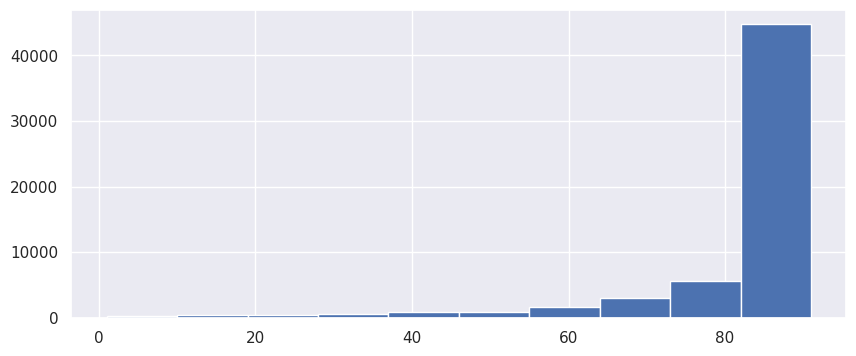

In [5]:
train.loc[train['target'] == 0, 'time'].hist(figsize=(10, 4));

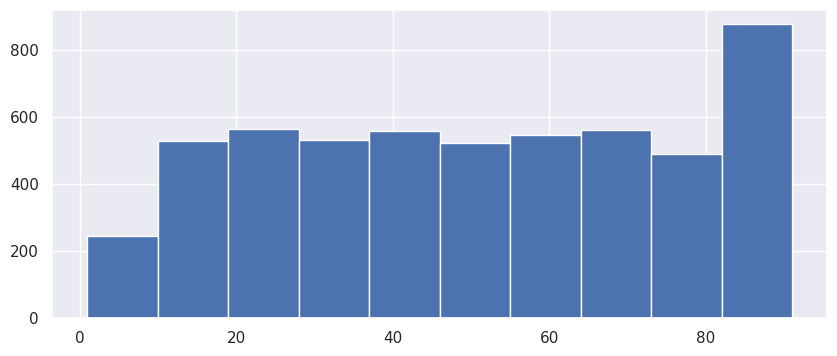

In [6]:
train.loc[train['target'] == 1, 'time'].hist(figsize=(10, 4));

Из графиков видно, что ситуация для клиентов попавших в отток и не попавших (target = 1 и target = 0 соответственно) распределение по времени сильно отличается. Это неудивительно так как у клиентов не попавших в отток скорей всего последняя транзакция была не так давно, то есть у большинства time лежит в диапозоне 80-90 дней, а у попавших в отток распредление более равномерное.

### 2) Файл "clients"

Данные о всех 96000 клиентах. В колонке "report" указывается номер отчёта, в котором была собрана информации по транзакциям о данном клиенте. В "employee_count_nm" информация о числе сотрудников в компании, в которой работает данный клиента. В "bankemplstatus" информация о том является ли клиент сотрудником банка. И в "customer_age" возраст клиента (4 группы: 0, 1, 2, 3)

In [7]:
clients.shape

(96000, 5)

In [8]:
clients.head()

,user_id,report,employee_count_nm,bankemplstatus,customer_age
0,3,2,ОТ 101 ДО 500,0,3
1,9,1,БОЛЕЕ 1001,0,3
2,13,6,ОТ 501 ДО 1000,0,2
3,37,5,БОЛЕЕ 1001,0,2
4,41,1,ОТ 101 ДО 500,0,2


Посмотрим на распределение категориальных признаков:

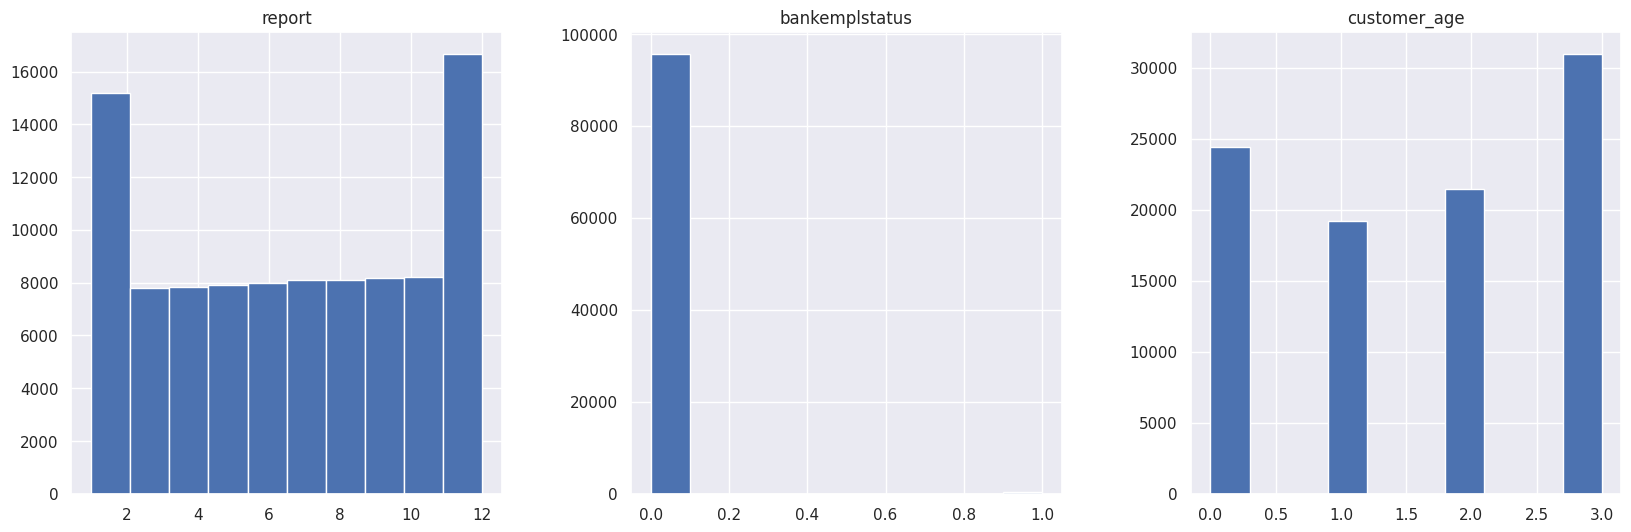

In [9]:
clients.drop(["user_id", "employee_count_nm"], axis=1).hist(figsize=(20, 6), layout=(-1, 3));

In [10]:
clients['employee_count_nm'].value_counts()

employee_count_nm
БОЛЕЕ 1001        17833
ОТ 101 ДО 500     14362
ОТ 51 ДО 100       7314
ОТ 501 ДО 1000     6481
ОТ 11 ДО 50        4413
ДО 10              3797
БОЛЕЕ 500          1996
ОТ 11 ДО 30        1871
ОТ 31 ДО 50        1467
Name: count, dtype: int64

In [11]:
clients['bankemplstatus'].value_counts(normalize=True)

bankemplstatus
0    0.99674
1    0.00326
Name: proportion, dtype: float64

### 3) report dates и transactions

Всего 12 отчётов, отчёт проводится каждый месяц и в каждый отчёт попадают не все клиенты

In [12]:
report_dates

,report,report_dt
0,1,2022-07-31 03:00:00
1,2,2022-08-31 03:00:00
2,3,2022-09-30 03:00:00
3,4,2022-10-31 03:00:00
4,5,2022-11-30 03:00:00
5,6,2022-12-31 03:00:00
6,7,2023-01-31 03:00:00
7,8,2023-02-28 03:00:00
8,9,2023-03-31 03:00:00
9,10,2023-04-30 03:00:00


В файле "transcations" содержится список транзакций для каждого клиента:
1. "mcc_code" - информация о коде транзакций(что за операция совершалась): 322 уникальных кода
2. "currency_rk" информация о валюте транзакции: 4 разны валюты 
3. "transaction_amt" сумма в валюте транзакции
4. "transaction_dttm" дата и время совершение транзакции

In [13]:
tran.shape

(13075023, 5)

In [14]:
tran.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,3,1,-183.883957,2022-01-28 12:05:33
1,3,3,1,-3206.437012,2022-01-28 12:52:30
2,3,16,1,-153866.890625,2022-02-16 14:45:56
3,3,56,1,-15144.601562,2022-03-09 19:58:29
4,3,0,1,5297.908691,2022-03-12 18:11:31


Видно что есть транзакции с положительной суммой и отрицательной, судя по всему эту поступление денег на счёт и списание денег со счёта. Сходу можно сказать, что создание отдельных признаков для положительных и отрицательных транзакций может помочь моделе предсказывать отток лучше.

Посмотрим на распределение категориальных признаков:

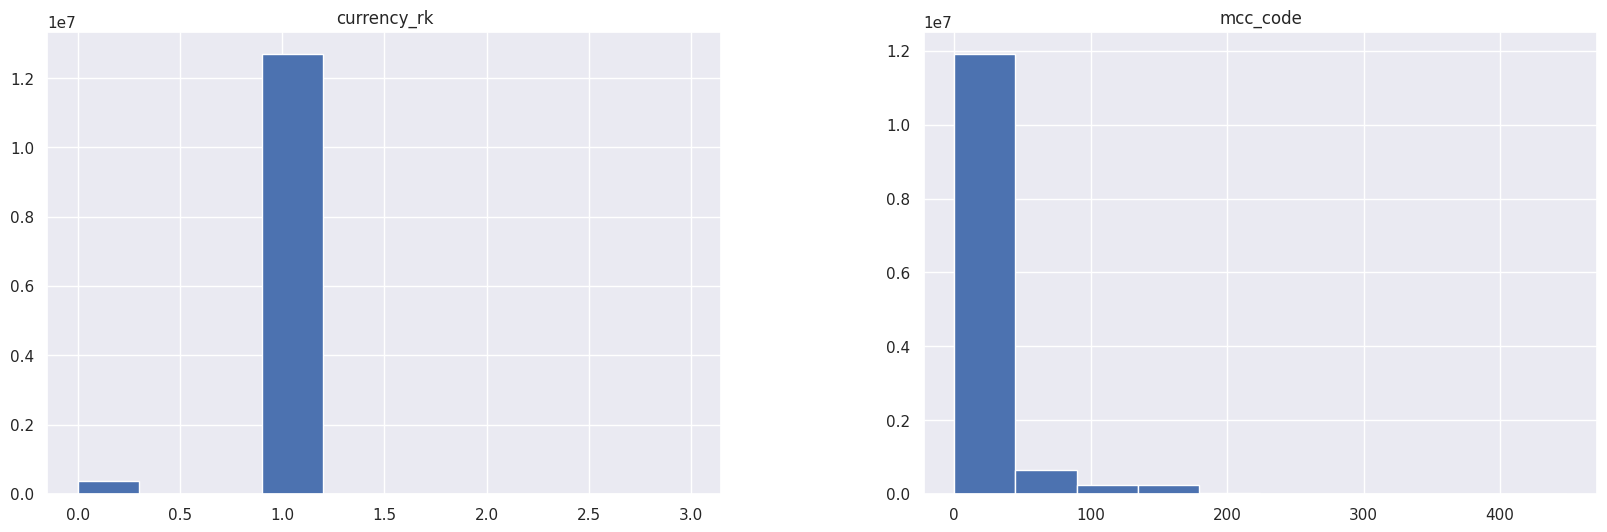

In [15]:
tran[['currency_rk', 'mcc_code']].hist(figsize=(20, 6), layout=(-1, 2));

In [16]:
tran['currency_rk'].value_counts(normalize=True)

currency_rk
1    0.971396
0    0.028333
3    0.000137
2    0.000134
Name: proportion, dtype: float64

In [17]:
tran['mcc_code'].value_counts(normalize=True)

mcc_code
1      3.176020e-01
2      8.148077e-02
4      7.248324e-02
3      5.502094e-02
0      4.452589e-02
           ...     
434    7.648170e-08
273    7.648170e-08
323    7.648170e-08
243    7.648170e-08
314    7.648170e-08
Name: proportion, Length: 332, dtype: float64

Из этого следует, что чащего всего транзакции проходят в валюте 1 (97%) и что 32% транзакций соответствуют коду 1. Скорей всего нужно будет строить признаки, учитывающие суммы транзакций в разных валютах и соотвествующие разным mcc кодам. 

# 2. Обработка данных и генерация новых признаков

### 1) Кодируем признак employee

In [18]:
employee = {'ОТ 101 ДО 500':4,'БОЛЕЕ 1001':6,'ОТ 501 ДО 1000':5,'ДО 10':1,
            'ОТ 11 ДО 50':2,'ОТ 51 ДО 100':3,'БОЛЕЕ 500':5,'ОТ 11 ДО 30':2,
            'ОТ 31 ДО 50':2}
clients.loc[:, 'employee_count_nm'] = clients['employee_count_nm'].apply(lambda x: employee.get(x, 'NaN'))

In [19]:
clients['employee_count_nm'].value_counts()

employee_count_nm
NaN    36466
6      17833
4      14362
5       8477
2       7751
3       7314
1       3797
Name: count, dtype: int64

Видим что есть очень много пропусков, возможно это стоит рассматривать как отдельную категорию. Может быть это клиенты не с зарплатными картами, поэтому количество сотрудников не указано

### 2) Генерируем признаки по сумме и количеству транзакций каждого клиента

In [20]:
tran.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,3,1,-183.883957,2022-01-28 12:05:33
1,3,3,1,-3206.437012,2022-01-28 12:52:30
2,3,16,1,-153866.890625,2022-02-16 14:45:56
3,3,56,1,-15144.601562,2022-03-09 19:58:29
4,3,0,1,5297.908691,2022-03-12 18:11:31


**Перевёдем время транзакций в нужный формат:**

In [21]:
# перевод в нужный формат
tran['transaction_dttm'] = tran['transaction_dttm'].astype('datetime64[ns]')
# день недели транзакции
tran['dayofweek'] = tran['transaction_dttm'].dt.dayofweek
# дата транзакции год-месяц-число
tran['date'] = tran['transaction_dttm'].dt.date.astype('datetime64[ns]')

In [22]:
tran.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,dayofweek,date
0,3,3,1,-183.883957,2022-01-28 12:05:33,4,2022-01-28
1,3,3,1,-3206.437012,2022-01-28 12:52:30,4,2022-01-28
2,3,16,1,-153866.890625,2022-02-16 14:45:56,2,2022-02-16
3,3,56,1,-15144.601562,2022-03-09 19:58:29,2,2022-03-09
4,3,0,1,5297.908691,2022-03-12 18:11:31,5,2022-03-12


**Разделим транзакции на отрицательные(олата или перевод) и положительные(пополнение баланса):**

In [23]:
# положительные транзакции
tran['transaction_positive'] = np.where(tran['transaction_amt']>0,tran['transaction_amt'],0) 
# отрицательные транзакции
tran['transaction_negative'] = np.where( tran['transaction_amt']<0,tran['transaction_amt'],0)

**Создадим признаки с суммой транзакций каждого клиента в каждой валюте:**

In [24]:
# перевод в логарифмическую шкалу,для того чтобы не работать с большими числами
def logsumabs(x):
    sumabs = x.abs().sum()
    if sumabs > 0:
        return np.log(sumabs)
    else:
        return 0

In [25]:
# сумма транзакций каждого клиента в определенной валюте
monetary = tran.groupby(['user_id', 'currency_rk'])['transaction_amt'].agg(
    [logsumabs]
)
monetary = monetary.unstack().fillna(0)
monetary.columns = ['logsum_0','logsum_1','logsum_2','logsum_3']

# количество валют, в которых клиента проводил транзакции
monetary['currency_nunique'] = (monetary != 0).sum(axis=1)

monetary.head()

,logsum_0,logsum_1,logsum_2,logsum_3,currency_nunique
user_id,,,,,
3,0.00000,12.789712,0.0,0.0,1
9,0.00000,12.686752,0.0,0.0,1
13,9.28478,12.825245,0.0,0.0,2
37,0.00000,12.775178,0.0,0.0,1
41,0.00000,11.595303,0.0,0.0,1


**Тоже самое, но только отдельно для положительных и отрицательных транзакций:**

Также кроме суммы посчитаем количество транзакций:

In [26]:
# для положительных
monetary_positive = tran.groupby(['user_id', 'currency_rk'])['transaction_positive'].agg(
    [logsumabs, lambda x: (x != 0).sum()]
)
monetary_positive = monetary_positive.unstack().fillna(0)
monetary_positive.columns = ['logsum_pos_0','logsum_pos_1','logsum_pos_2','logsum_pos_3',
                     'count_pos_0', 'count_pos_1', 'count_pos_2', 'count_pos_3']
monetary_positive.head()

,logsum_pos_0,logsum_pos_1,logsum_pos_2,logsum_pos_3,count_pos_0,count_pos_1,count_pos_2,count_pos_3
user_id,,,,,,,,
3,0.00000,12.134084,0.0,0.0,0.0,7.0,0.0,0.0
9,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13,9.28478,11.678388,0.0,0.0,1.0,7.0,0.0,0.0
37,0.00000,9.281618,0.0,0.0,0.0,2.0,0.0,0.0
41,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# для отрицательных
monetary_negative = tran.groupby(['user_id', 'currency_rk'])['transaction_negative'].agg(
    [logsumabs, lambda x: (x != 0).sum()])
monetary_negative = monetary_negative.unstack().fillna(0)
monetary_negative.columns = ['sum_neg_0','sum_neg_1','sum_neg_2','sum_neg_3',
                     'count_neg_0', 'count_neg_1', 'count_neg_2', 'count_neg_3']
monetary_negative.head()

,sum_neg_0,sum_neg_1,sum_neg_2,sum_neg_3,count_neg_0,count_neg_1,count_neg_2,count_neg_3
user_id,,,,,,,,
3,0.0,12.057583,0.0,0.0,0.0,4.0,0.0,0.0
9,0.0,12.686752,0.0,0.0,0.0,90.0,0.0,0.0
13,0.0,12.443056,0.0,0.0,0.0,14.0,0.0,0.0
37,0.0,12.744314,0.0,0.0,0.0,313.0,0.0,0.0
41,0.0,11.595303,0.0,0.0,0.0,16.0,0.0,0.0


**В итоге получили 3 таблицы признаков: monetory, monetory_positive и monetory_negative.**

### 3) Разбиение по mcc кодам транзакций каждого клиента

**Будем рассматривать mcc коды, которые присутствуют хотя бы в 10 транзакциях:**

In [28]:
mask = tran['mcc_code'].value_counts() > 10
mcc_codes = tran['mcc_code'].value_counts()[mask].index
len(mcc_codes)

286

**Создадим сводную таблицу с суммой транзакций по каждому mcc коду для каждого клиента:**

In [29]:
sum_mcc_code = tran[tran['mcc_code'].isin(mcc_codes)].pivot_table(    
    values="transaction_amt",
    index="user_id",
    columns="mcc_code",
    aggfunc="sum",
    fill_value=0,)
sum_mcc_code.columns = list(map(lambda x: "sum_mcc_code"+str(x), sum_mcc_code.columns))
sum_mcc_code

,sum_mcc_code0,sum_mcc_code1,sum_mcc_code2,sum_mcc_code3,sum_mcc_code4,sum_mcc_code6,sum_mcc_code7,sum_mcc_code8,sum_mcc_code9,sum_mcc_code10,...,sum_mcc_code326,sum_mcc_code327,sum_mcc_code328,sum_mcc_code332,sum_mcc_code334,sum_mcc_code338,sum_mcc_code360,sum_mcc_code364,sum_mcc_code382,sum_mcc_code413
user_id,,,,,,,,,,,,,,,,,,,,,
3,186108.229797,0.000000,0.000000,-3390.320969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,-20556.742374,-8324.033737,-192534.730225,-1664.872650,-2037.417374,0.000000,-5204.533508,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.000000,0.000000,0.000000,-160818.399902,0.000000,0.000000,-5997.509766,0.000000,10805.421875,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,10738.788574,-35943.518551,-26588.514793,-214788.286194,-126.869576,-653.359955,0.000000,-1031.058945,-26518.769531,-924.123138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0.000000,-740.059052,0.000000,-70219.408691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562043,0.000000,-7254.742481,0.000000,-13020.519531,0.000000,-1303.106201,-786.304443,-870.556900,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562205,-10868.047920,-12028.663424,-1157.922058,0.000000,-129.403091,-6800.897217,0.000000,-2645.133282,0.000000,-770.019485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562312,0.000000,-6974.722969,-352.799313,0.000000,-1372.377075,-2114.061485,0.000000,-988.508408,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Теперь с количеством транзакций:**

In [30]:
# количество транзакций для каждого mcc кода
count_mcc_code = tran[tran['mcc_code'].isin(mcc_codes)].pivot_table(    
    values="transaction_amt",
    index="user_id",
    columns="mcc_code",
    aggfunc="count",
    fill_value=0,)
count_mcc_code.columns = list(map(lambda x: "count_mcc_code_"+str(x), count_mcc_code.columns))

# количество mcc кодов через которые проходили транзакции для каждого клиента
count_mcc_code['nunique_mcc_code'] = (count_mcc_code != 0).sum(axis=1)

count_mcc_code

,count_mcc_code_0,count_mcc_code_1,count_mcc_code_2,count_mcc_code_3,count_mcc_code_4,count_mcc_code_6,count_mcc_code_7,count_mcc_code_8,count_mcc_code_9,count_mcc_code_10,...,count_mcc_code_327,count_mcc_code_328,count_mcc_code_332,count_mcc_code_334,count_mcc_code_338,count_mcc_code_360,count_mcc_code_364,count_mcc_code_382,count_mcc_code_413,nunique_mcc_code
user_id,,,,,,,,,,,,,,,,,,,,,
3,7,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
9,0,27,11,5,3,2,0,6,0,0,...,0,0,0,0,0,0,0,0,0,22
13,0,0,0,14,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,4
37,2,97,129,28,1,2,0,7,1,4,...,0,0,0,0,0,0,0,0,0,28
41,0,2,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562043,0,19,0,1,0,1,3,4,0,0,...,0,0,0,0,0,0,0,0,0,12
562205,30,33,2,0,1,10,0,6,0,3,...,0,0,0,0,0,0,0,0,0,15
562312,0,24,3,0,1,6,0,4,0,0,...,0,0,0,0,0,0,0,0,0,7


**Таким образом, создали ещё две таблицы: "sum_mcc_code" и "count_mcc_code".**

### 4) Генерируем признаки по времени транзакций

**Дополним таблицу с транзакциями информацией о клиенте и о дате отчёта, в который попал клиент:**

In [31]:
# Переведём дату отчётов в нужный формат
report_dates["report_dt"] = report_dates["report_dt"].astype('datetime64[ns]')

# Объединим с таблицей о клиентах -> теперь есть дата отчёта для каждого клиента
clients_report = clients.merge(report_dates, on='report', how='left')

# Теперь для каждой транзакции таблицы tran добавим информацию из таблице clients_report
tran_clients = tran.merge(clients_report ,on="user_id", how="left")

tran_clients.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,dayofweek,date,transaction_positive,transaction_negative,report,employee_count_nm,bankemplstatus,customer_age,report_dt
0,3,3,1,-183.883957,2022-01-28 12:05:33,4,2022-01-28,0.000000,-183.883957,2,4,0,3,2022-08-31 03:00:00
1,3,3,1,-3206.437012,2022-01-28 12:52:30,4,2022-01-28,0.000000,-3206.437012,2,4,0,3,2022-08-31 03:00:00
2,3,16,1,-153866.890625,2022-02-16 14:45:56,2,2022-02-16,0.000000,-153866.890625,2,4,0,3,2022-08-31 03:00:00
3,3,56,1,-15144.601562,2022-03-09 19:58:29,2,2022-03-09,0.000000,-15144.601562,2,4,0,3,2022-08-31 03:00:00
4,3,0,1,5297.908691,2022-03-12 18:11:31,5,2022-03-12,5297.908691,0.000000,2,4,0,3,2022-08-31 03:00:00


In [32]:
tran_clients.shape

(13075023, 14)

**Добавим признаки "diff_days" и "m":**

In [33]:
# количество дней от транзакции до отчёта
tran_clients['diff_days'] = (tran_clients['report_dt']-tran_clients['transaction_dttm']).dt.days

# количество месяцев от транзакции до отчёта
tran_clients['m'] = ((tran_clients['report_dt'].dt.year - tran_clients['transaction_dttm'].dt.year)*12
                    +(tran_clients['report_dt'].dt.month -tran_clients['transaction_dttm'].dt.month))

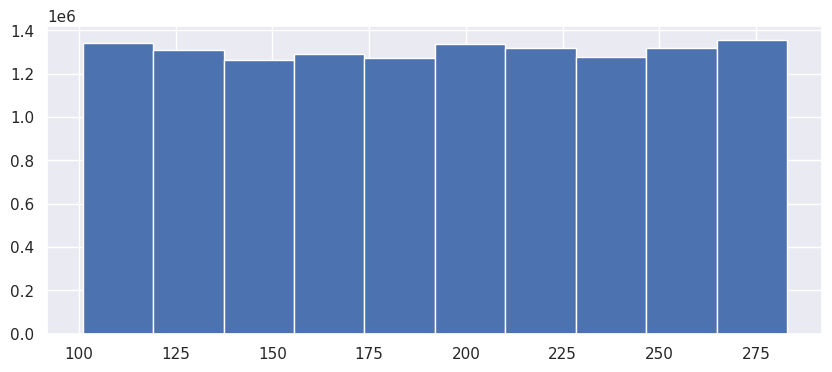

In [34]:
tran_clients['diff_days'].hist(figsize=(10, 4));

То есть нам даны транзакции в промежутке: [3 месяца до отчёта, 9 месяцев до отчёта] или примерно [100 дней, 280 дней], первые же три месяц используются для построения переменной time - дата последней транзакции в эти три месяца.

**Сумма положительных транзакций каждый месяц:**

In [35]:
monetary_positive_month = tran_clients.pivot_table(values="transaction_positive",                              
    index="user_id",
    columns="m",
    aggfunc=logsumabs,
    fill_value=0,)
monetary_positive_month.columns = list( map(lambda x: "monetary_positive_month_"+str(x), monetary_positive_month.columns ) )
monetary_positive_month

,monetary_positive_month_3,monetary_positive_month_4,monetary_positive_month_5,monetary_positive_month_6,monetary_positive_month_7,monetary_positive_month_8,monetary_positive_month_9
user_id,,,,,,,
3,11.833084,10.670715,8.575067,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,9.287803,9.301288,0.000000,11.364404,9.214152,9.284780,0.000000
37,0.000000,0.000000,8.610163,8.566297,0.000000,0.000000,0.000000
41,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
562043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
562205,5.768060,0.000000,0.000000,0.000000,0.000000,0.000000,7.407918
562312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


**Сумма отрицательных транзакций каждый месяц:**

In [36]:
monetary_negative_month = tran_clients.pivot_table(values="transaction_negative",                              
    index="user_id",
    columns="m",
    aggfunc=logsumabs,
    fill_value=0,)
monetary_negative_month.columns = list( map(lambda x: "monetary_negative_month_"+str(x), monetary_negative_month.columns ) )
monetary_negative_month

,monetary_negative_month_3,monetary_negative_month_4,monetary_negative_month_5,monetary_negative_month_6,monetary_negative_month_7,monetary_negative_month_8,monetary_negative_month_9
user_id,,,,,,,
3,0.000000,0.000000,9.625399,11.943843,8.128680,0.000000,0.000000
9,9.494728,11.554290,11.606416,10.899446,9.825543,9.424449,9.313587
13,9.704682,10.207114,10.227409,11.240943,10.431418,10.878501,9.863950
37,10.395736,10.630183,11.113665,10.884106,11.152946,10.820914,10.250063
41,8.992861,9.781772,10.320704,9.767794,9.807809,9.731584,0.000000
...,...,...,...,...,...,...,...
562043,0.000000,4.956226,0.000000,8.001098,9.312899,9.640494,0.000000
562205,9.254623,8.928839,8.795084,8.480752,8.713114,8.631835,7.207300
562312,0.000000,7.880288,7.216911,8.060080,8.278505,8.410861,7.983247


**Количества транзакций каждый месяц в каждой валюте:**

In [37]:
month_currency_count = tran_clients.pivot_table(values="transaction_amt",
    index="user_id",
    columns=["m","currency_rk"],
    aggfunc='count',
    fill_value=0,)
month_currency_count.columns = list(
    map(lambda x: f"month_{str(x[0])}_currency_{str(x[1])}_count", month_currency_count.columns))
month_currency_count

,month_3_currency_0_count,month_3_currency_1_count,month_3_currency_2_count,month_3_currency_3_count,month_4_currency_0_count,month_4_currency_1_count,month_4_currency_2_count,month_4_currency_3_count,month_5_currency_0_count,month_5_currency_1_count,...,month_7_currency_2_count,month_7_currency_3_count,month_8_currency_0_count,month_8_currency_1_count,month_8_currency_2_count,month_8_currency_3_count,month_9_currency_0_count,month_9_currency_1_count,month_9_currency_2_count,month_9_currency_3_count
user_id,,,,,,,,,,,,,,,,,,,,,
3,0,3,0,0,0,3,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
9,0,8,0,0,0,15,0,0,0,9,...,0,0,0,9,0,0,0,14,0,0
13,0,2,0,0,0,3,0,0,0,2,...,0,0,1,3,0,0,0,1,0,0
37,0,15,0,0,0,77,0,0,0,67,...,0,0,0,37,0,0,0,10,0,0
41,0,2,0,0,0,4,0,0,0,3,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562043,0,0,0,0,0,1,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0
562205,0,12,0,0,0,29,0,0,0,33,...,0,0,0,23,0,0,0,8,0,0
562312,0,0,0,0,0,10,0,0,0,5,...,0,0,0,14,0,0,0,7,0,0


**Построим признаки, основываясь на количестве дней между транзакциями каждого клиента:**

In [38]:
date_trans = tran_clients.groupby("user_id").agg({"date":"unique"}).explode("date").reset_index()
date_trans["interval"]=date_trans.groupby("user_id")["date"].diff()
date_trans

,user_id,date,interval
0,3,2022-01-28,NaT
1,3,2022-02-16,19 days
2,3,2022-03-09,21 days
3,3,2022-03-12,3 days
4,3,2022-04-11,30 days
...,...,...,...
5601163,562740,2023-03-15,1 days
5601164,562740,2023-03-17,2 days
5601165,562740,2023-03-18,1 days
5601166,562740,2023-03-19,1 days


In [39]:
date_trans = date_trans.dropna() 
date_trans.loc[:,"interval"] = date_trans["interval"].dt.days
tran_days_interval = date_trans.groupby("user_id").agg({"interval":["last", "max", "median"]})
tran_days_interval.columns = ['tran_days_interval_last', 'tran_days_interval_max', 'tran_days_median']
tran_days_interval

/tmp/ipykernel_34/2278343277.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 21  3 ...  1  1  1]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  date_trans.loc[:,"interval"] = date_trans["interval"].dt.days


,tran_days_interval_last,tran_days_interval_max,tran_days_median
user_id,,,
3,9,30,18.0
9,17,22,2.0
13,2,21,9.0
37,1,7,1.0
41,2,31,4.0
...,...,...,...
562043,54,54,1.5
562205,1,8,1.0
562312,2,37,2.0


### 5) Собираем всё вместе

In [40]:
df = clients_report.merge(
                monetary, on="user_id", how="left"
                ).merge(monetary_positive, on="user_id", how="left"
                ).merge(monetary_negative, on="user_id", how="left"
                ).merge(sum_mcc_code, on="user_id", how="left"
                ).merge(count_mcc_code, on="user_id", how="left"
                ).merge(monetary_positive_month, on="user_id", how="left"
                ).merge(monetary_negative_month, on="user_id", how="left"
                ).merge(month_currency_count, on="user_id", how="left"
                ).merge(tran_days_interval, on="user_id", how="left"      
                ).merge(train, on="user_id", how="left"
                )

df['time'] = df['time'].fillna(-1)
df['time'] = df['time'].astype(np.int32)
df['target'] = df['target'].fillna(-1)
df['target'] = df['target'].astype(np.int8)

df.head()

,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_dt,logsum_0,logsum_1,logsum_2,logsum_3,...,month_8_currency_3_count,month_9_currency_0_count,month_9_currency_1_count,month_9_currency_2_count,month_9_currency_3_count,tran_days_interval_last,tran_days_interval_max,tran_days_median,target,time
0,3,2,4,0,3,2022-08-31 03:00:00,0.00000,12.789712,0.0,0.0,...,0,0,0,0,0,9.0,30.0,18.0,0,77
1,9,1,6,0,3,2022-07-31 03:00:00,0.00000,12.686752,0.0,0.0,...,0,0,14,0,0,17.0,22.0,2.0,-1,-1
2,13,6,5,0,2,2022-12-31 03:00:00,9.28478,12.825245,0.0,0.0,...,0,0,1,0,0,2.0,21.0,9.0,0,86
3,37,5,6,0,2,2022-11-30 03:00:00,0.00000,12.775178,0.0,0.0,...,0,0,10,0,0,1.0,7.0,1.0,0,89
4,41,1,4,0,2,2022-07-31 03:00:00,0.00000,11.595303,0.0,0.0,...,0,0,0,0,0,2.0,31.0,4.0,0,57


In [41]:
df.shape

(96000, 647)

## 3. Обучение catboost

**На данном этапе попробуем обучить catboost без учёта "time", то есть будем рассматривать эту задачу как обычную задачу оттока. Во втором ноутбуке задача рассмотрена с точки зрения анализа выживаемости(survival analysis).**

Этот вариант решения рассматривается как baseline, поэтому тут я не пытался подбирать гиперпараметры и выбивать наибольший скор, так как заранее было понятно, что без учёта "time" наилучший скор не получить.

### 1) Обучение c hold-out

Разбиваем данные, в которых известен таргет на train и eval:

In [42]:
X = df.loc[df['time'] != -1, :].drop(['user_id', 'target', 'time'], axis=1)
y = df.loc[df['time'] != -1, 'target']

In [44]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

обучаем модель:

In [45]:
%%time
cat = CatBoostClassifier(
    iterations=14000,    
    learning_rate= 0.003, 
    depth=10,
    custom_metric=['AUC'], 
    eval_metric="AUC", 
    random_seed=42, 
    task_type="GPU", devices='0:1',
)

cat_features = ["bankemplstatus","customer_age"]
cat.fit(
    X_train,y_train,
    eval_set=(X_eval, y_eval),
    cat_features=cat_features,
    early_stopping_rounds=500,
    verbose=1000,
    use_best_model=True)
cat.best_score_

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6813115	best: 0.6813115 (0)	total: 14.1s	remaining: 2d 7h 1m 16s
1000:	test: 0.7540542	best: 0.7540563 (999)	total: 1m 53s	remaining: 24m 31s
2000:	test: 0.7626612	best: 0.7626612 (2000)	total: 3m 36s	remaining: 21m 40s
3000:	test: 0.7663765	best: 0.7663774 (2999)	total: 5m 20s	remaining: 19m 33s
4000:	test: 0.7690579	best: 0.7690666 (3996)	total: 7m 3s	remaining: 17m 38s
5000:	test: 0.7708311	best: 0.7708391 (4999)	total: 8m 47s	remaining: 15m 49s
6000:	test: 0.7723823	best: 0.7723856 (5998)	total: 10m 31s	remaining: 14m 1s
7000:	test: 0.7736156	best: 0.7736156 (7000)	total: 12m 15s	remaining: 12m 15s
8000:	test: 0.7742943	best: 0.7743533 (7950)	total: 13m 59s	remaining: 10m 29s
9000:	test: 0.7749131	best: 0.7749162 (8996)	total: 15m 43s	remaining: 8m 44s
10000:	test: 0.7752668	best: 0.7752799 (9980)	total: 17m 28s	remaining: 6m 59s
bestTest = 0.7754918635
bestIteration = 10457
Shrink model to first 10458 iterations.
CPU times: user 20min 43s, sys: 56.4 s, total: 21min 40s


{'learn': {'Logloss': 0.18326541900634766},
 'validation': {'Logloss': 0.2463226318359375, 'AUC': 0.775491863489151}}

Посмотрим на важность признаков:

In [55]:
cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,employee_count_nm,7.032951e+00
1,customer_age,4.626240e+00
2,monetary_negative_month_3,4.149249e+00
3,tran_days_interval_max,2.851501e+00
4,monetary_negative_month_4,2.736055e+00
...,...,...
639,count_mcc_code_317,1.610207e-06
640,sum_mcc_code327,4.153332e-07
641,sum_mcc_code270,0.000000e+00
642,sum_mcc_code310,0.000000e+00


Делаем предсказание вероятности оттока:

In [50]:
X_test = df.loc[df['time']==-1, :].drop(['user_id', 'target', 'time'], axis=1)

predictions = cat.predict_proba(X_test)[:, 1]

submit = pd.DataFrame(predictions, index=df[df['time']==-1]['user_id'].values, columns=['predict']) 
submit

,predict
9,0.018817
61,0.016070
62,0.046250
80,0.005307
88,0.125062
...,...
561362,0.053562
561419,0.046834
561895,0.056155
561908,0.059724


In [51]:
submit.to_csv('catboost_0.csv',index_label='user_id')

### 2) Обучение c K-Fold

Не забываем, что у нас есть дисбаланс классов, поэтому применяем стратифицированный k-fold

In [52]:
n_splits=5
scores = []
models = []

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_index, val_index in skf.split(X, y):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    

    model = CatBoostClassifier(
        iterations=14000,    
        learning_rate= 0.003, 
        depth=10, 
        eval_metric="AUC", 
        random_seed=42, 
        task_type="GPU", devices='0:1',
    )


    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=500,
              cat_features=cat_features,
              verbose=3000,
              use_best_model=True)
    
    models.append(model)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    scores.append(roc_auc_score(y_val, y_pred))

np.mean(scores)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6924093	best: 0.6924093 (0)	total: 114ms	remaining: 26m 32s
3000:	test: 0.7581418	best: 0.7581418 (3000)	total: 5m 7s	remaining: 18m 46s
6000:	test: 0.7652581	best: 0.7652663 (5987)	total: 10m 19s	remaining: 13m 45s
9000:	test: 0.7681595	best: 0.7681595 (9000)	total: 15m 30s	remaining: 8m 36s
12000:	test: 0.7697309	best: 0.7697309 (12000)	total: 20m 42s	remaining: 3m 27s
13999:	test: 0.7703435	best: 0.7703512 (13985)	total: 24m 11s	remaining: 0us
bestTest = 0.7703511715
bestIteration = 13985
Shrink model to first 13986 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6901211	best: 0.6901211 (0)	total: 104ms	remaining: 24m 9s
3000:	test: 0.7678352	best: 0.7678352 (3000)	total: 5m 6s	remaining: 18m 42s
6000:	test: 0.7739926	best: 0.7740238 (5969)	total: 10m 18s	remaining: 13m 44s
9000:	test: 0.7761215	best: 0.7761531 (8865)	total: 15m 30s	remaining: 8m 36s
bestTest = 0.7765896022
bestIteration = 9954
Shrink model to first 9955 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6868605	best: 0.6868605 (0)	total: 104ms	remaining: 24m 9s
3000:	test: 0.7680473	best: 0.7680535 (2999)	total: 5m 7s	remaining: 18m 45s
6000:	test: 0.7723407	best: 0.7723490 (5994)	total: 10m 18s	remaining: 13m 43s
bestTest = 0.773157537
bestIteration = 7381
Shrink model to first 7382 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6632235	best: 0.6632235 (0)	total: 104ms	remaining: 24m 11s
3000:	test: 0.7579486	best: 0.7579486 (3000)	total: 5m 7s	remaining: 18m 47s
6000:	test: 0.7638324	best: 0.7638335 (5996)	total: 10m 19s	remaining: 13m 45s
9000:	test: 0.7654468	best: 0.7655256 (8954)	total: 15m 30s	remaining: 8m 37s
bestTest = 0.7655994296
bestIteration = 9478
Shrink model to first 9479 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6719270	best: 0.6719270 (0)	total: 103ms	remaining: 24m 6s
3000:	test: 0.7588026	best: 0.7588116 (2989)	total: 5m 6s	remaining: 18m 43s
6000:	test: 0.7641807	best: 0.7641979 (5973)	total: 10m 18s	remaining: 13m 44s
9000:	test: 0.7657548	best: 0.7657631 (8996)	total: 15m 31s	remaining: 8m 37s
bestTest = 0.7659589648
bestIteration = 10899
Shrink model to first 10900 iterations.


0.7703311175098639

Делаем предсказание и усредняем сумму предсказаний всех моделей:

In [53]:
predictions = models[0].predict_proba(df[df['time']==-1][df.columns[1:-2]])[:,1]
for i in range(1, len(models)):
    predictions += models[i].predict_proba(df[df['time']==-1][df.columns[1:-2]])[:,1]
predict = predictions / 5
submit = pd.DataFrame(predict, index=df[df['time']==-1]['user_id'].values, columns=['predict'])
submit

,predict
9,0.020957
61,0.018105
62,0.047413
80,0.005483
88,0.123114
...,...
561362,0.053726
561419,0.049329
561895,0.051606
561908,0.065555


In [54]:
submit.to_csv('catboost_1.csv',index_label='user_id') 

**Таким образом, удалось добиться 0,776 на public, что позволило войти в топ-100. В следующем ноутбуке разбирается подход, который позволил в итоге занять 25 место.**